# Entities

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cmx

In [4]:
import sys
sys.path.append("../")
from MapSci.papers import papers
from MapSci.research_space import research_space
from MapSci.entities import entities
import MapSci.agg as agg

TEXT

In [5]:
pp = papers("lattes")
maps = research_space("lattes", pp)
maps.compute(2000, 2014)

guevara(2000, 2014, 0.1)
chinazzi(2000, 2014, 0.1, 200)


TEXT

In [6]:
presence = pp.presence(2000, 2014)
indices = maps.phi["guevara(2000, 2014, 0.1)"][1]
scientists = entities(presence, indices)

TEXT

In [5]:
for i in scientists.rca:
    text = list()
    if i[0] == 9089204821424223:
        text.append("Laender:\t")
    elif i[0] == 2408991231058279:
        text.append("Ana:\t")
    else:
        continue
    
    text.append(i[1])
    text.append(str(scientists.rca[i]))
    print("{: >10} {: >50} {: >20}".format(*text))

 Laender:	                   library and information sciences      28.767891192982
 Laender:	       earth and planetary sciences (miscellaneous)    9.520489018707266
 Laender:	               computer networks and communications    64.75262851387437
 Laender:	                          hardware and architecture   144.41214794553673
 Laender:	                                           software    67.95302517976717
 Laender:	                                information systems   243.27897561767483
     Ana:	               computer networks and communications   421.81830940639924
 Laender:	                   computer science (miscellaneous)   17.110027530208136
 Laender:	               computational theory and mathematics    41.85239597300472
 Laender:	                      computer science applications   14.888199117454217
 Laender:	                            artificial intelligence    23.70410055738224
     Ana:	                                           software    68.98568564871822
 Lae

TEXT

In [7]:
inst, st = agg.get_insts(scientists.set, "../dataset/lattes/pesquisadores.csv", sep=";sep;")

In [7]:
inst[9089204821424223]

'universidade federal de minas gerais'

In [8]:
st[2408991231058279]

'31'

TEXT

In [8]:
x = agg.aggregate(presence[1], inst)
presence_inst = pp.presence(2000, 2014, x=x)
institutions = entities(presence_inst, indices)

TEXT

In [28]:
for i in institutions.rca:
    text = list()
    if i[0] != 'ministerio da fazenda':
        continue
    
    text.append(i[1])
    text.append(str(institutions.rca[i]))
    print("{: >60} {: >20}".format(*text))

                                  economics and econometrics   15.157924661150671
         economics, econometrics and finance (miscellaneous)   109.23621580235829
               political science and international relations    51.08424543457664
                             sociology and political science   11.960631001827617
                                                   marketing    74.02208364996503
                                                 development   29.710535906890307
                                                     finance   16.401401172670244
                                                  philosophy    2.193892328471256
                                         materials chemistry   1.3778452398388565
                                           organic chemistry   1.0743120159676425
                                       polymers and plastics    3.158952878130882
                                               health policy    4.973572466975929
                

TEXT

In [9]:
areas = pd.read_pickle("../dataset/SJR/areas.pkl")

In [159]:
dict_macro['veterinary']

'health sciences'

In [33]:
insts = [
    "universidade federal de minas gerais",
    "universidade federal de lavras",
    "universidade de sao paulo",
    "universidade federal da paraiba",
    "universidade federal rural de pernambuco",
    "pontificia universidade catolica de minas gerais",
    "petrobras",
    "ministerio da fazenda"
]

In [33]:
insts = [
    "universidade federal de minas gerais",
    "universidade federal de lavras",
    "instituto nacional de pesquisas espaciais",
    "fundacao oswaldo cruz"
]

TEXT

In [11]:
dict_macro = areas[["Classification", "Subject area"]].set_index("Classification").to_dict()["Subject area"]
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]
unique = sorted(areas["Classification"].unique().tolist())
unique = sorted(unique, key=lambda x: dict_macro[x])
size = Counter(areas["Classification"].tolist())
macro = dict()

for sf, rca in institutions.rca.items():
    if rca > 1:
        if (sf[0], dict_area[sf[1]]) in macro:
            macro[(sf[0], dict_area[sf[1]])] += 1 / size[dict_area[sf[1]]]
        else:
            macro[(sf[0], dict_area[sf[1]])] = 1 / size[dict_area[sf[1]]] 

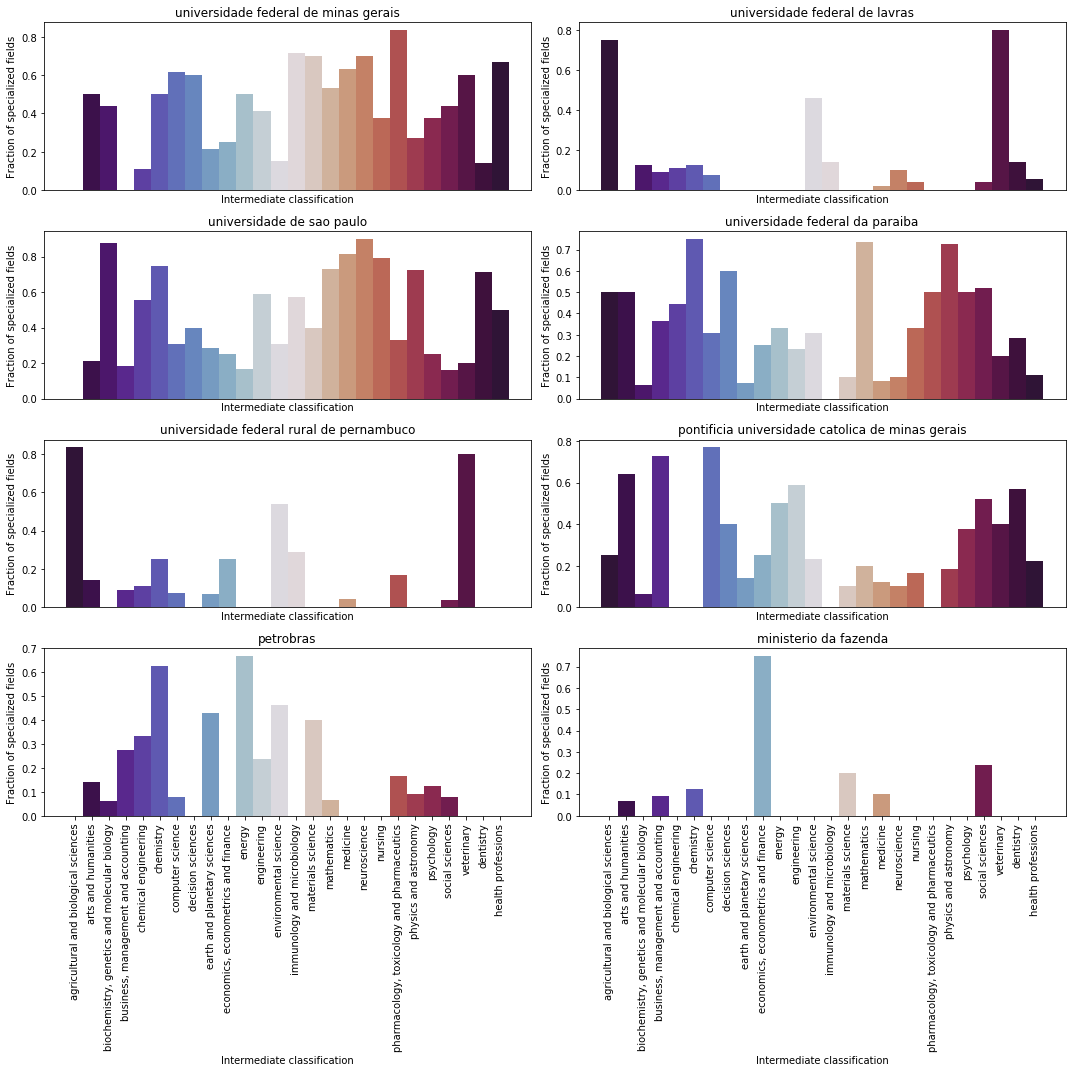

In [40]:
plt.rcParams["figure.figsize"] = (15,15)
cm = cmx.get_cmap('twilight_shifted', 26)
color = cm(np.linspace(0, 1, 26))
fig = plt.figure()

for i in range(len(insts)):
    uni = insts[i]
    areas_list = list()
    for a in unique:
        if (uni, a) in macro:
            areas_list.append(macro[(uni, a)])
        else:
            areas_list.append(0)

    sub = fig.add_subplot(4,2,i+1)
    plt.bar(unique, areas_list, color=color, width=1.0)
    plt.xticks(rotation=90)
    plt.title(uni)
    plt.ylabel("Fraction of specialized fields")
    plt.xlabel("Intermediate classification")
    if i < 6:
        sub.set_xticks([])
    
fig.tight_layout()
plt.show()

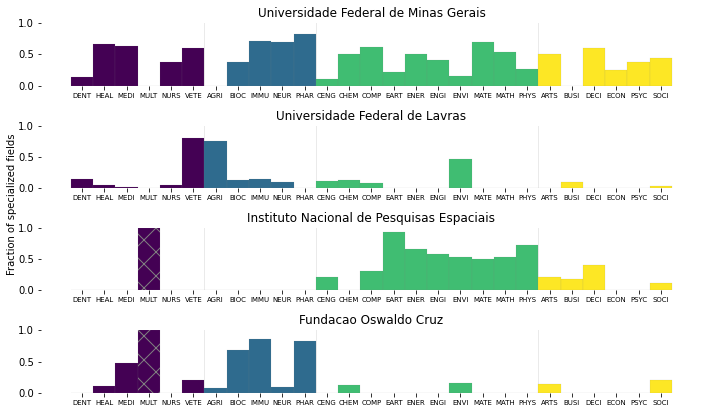

In [35]:
plt.rcParams["figure.figsize"] = (9.8,8.5)
cm = cmx.get_cmap('viridis', 27)
color = cm([0]*6 + [1/3]*5 +[2/3]*10 + [1]*6).tolist()
fig = plt.figure()
# xs = [str(x).zfill(2) for x in range(27)]
xs = [unique[x][:4].upper() for x in range(27)]
xs[11] = 'CENG'

for i in range(len(insts)):
    uni = insts[i]
    areas_list = list()
    for a in unique:
        if (uni, a) in macro:
            areas_list.append(macro[(uni, a)])
        else:
            areas_list.append(0)

    title = []
    for s in uni.split():
        if s not in ['da', 'de']:
            title.append(s.title())
        else:
            title.append(s)
    title = " ".join(title)
            
    ax = fig.add_subplot(6,1,i+1)
    ax.yaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax.yaxis.grid(zorder=0)
    bars = ax.bar(xs, areas_list, color=color, width=1, zorder=3, edgecolor='grey', lw=0.1)
    
    patterns = ["x" if i == 3 else "" for i in range(27)]
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)

    
    plt.xticks( size=7)
    plt.title(title)
    
#     if i == 1:
#         plt.ylabel("Fraction of specialized fields")
#     else:
#         plt.ylabel("")
    
#     plt.minorticks_on()
    plt.ylabel("")
    plt.xlabel("")
    plt.box(False)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,1))
    
    ax.plot([5.5,5.5], [0,1], color='#999999', linestyle='-', alpha=0.2, zorder=0,lw=1)
    ax.plot([10.5,10.5], [0,1], color='#999999', linestyle='-', alpha=0.2, zorder=0,lw=1)
    ax.plot([20.5,20.5], [0,1], color='#999999', linestyle='-', alpha=0.2, zorder=0,lw=1)
    
fig.text(0.00, 0.66, 'Fraction of specialized fields', va='center', rotation='vertical')
fig.tight_layout()
# plt.show()
plt.savefig("new plots/rca.pdf",bbox_inches='tight')

In [20]:
[(k[1], np.round(v,2)) for k,v in institutions.rca.items() if k[0] == "instituto nacional de pesquisas espaciais" and dict_area[k[1]] == "multidisciplinary"]

[('multidisciplinary', 1.27)]

In [18]:
dict_macro

{'multidisciplinary': 'health sciences',
 'agricultural and biological sciences': 'life sciences',
 'arts and humanities': 'social sciences & humanities',
 'biochemistry, genetics and molecular biology': 'life sciences',
 'business, management and accounting': 'social sciences & humanities',
 'chemical engineering': 'physical sciences',
 'chemistry': 'physical sciences',
 'computer science': 'physical sciences',
 'decision sciences': 'social sciences & humanities',
 'earth and planetary sciences': 'physical sciences',
 'economics, econometrics and finance': 'social sciences & humanities',
 'energy': 'physical sciences',
 'engineering': 'physical sciences',
 'environmental science': 'physical sciences',
 'immunology and microbiology': 'life sciences',
 'materials science': 'physical sciences',
 'mathematics': 'physical sciences',
 'medicine': 'health sciences',
 'neuroscience': 'life sciences',
 'nursing': 'health sciences',
 'pharmacology, toxicology and pharmaceutics': 'life sciences'

In [ ]:
print([6, 5, 10, 6])

In [42]:
import matplotlib.patheffects as path_effects

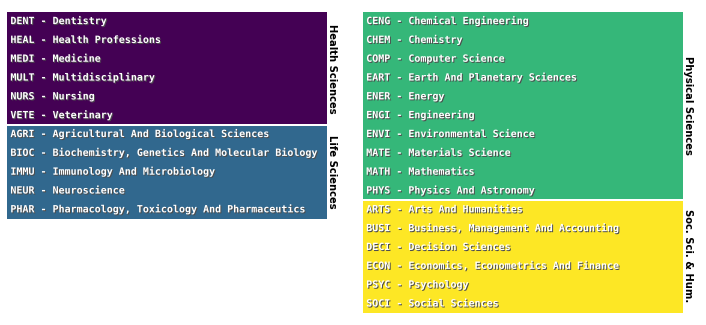

In [116]:
cm = cmx.get_cmap('viridis', 4)
color = cm([0]*6 + [1/3]*5).tolist() + [[1., 1., 1., 1.]]*5 + cm([2/3]*10 + [1]*6).tolist()

fig, ax = plt.subplots(1, 2, figsize=(9.8,4.5))
pd.Series([1 for _ in range(16)]).plot.barh(color=color[:16][::-1], width=1, ax=ax[0])
ax[0].plot([0,1], [9.5,9.5], color='white',lw=2)
# ax[0].plot([0,1], [2.5,2.5], color='white',lw=2)
ax[0].axis('off')
pd.Series([1 for _ in range(16)]).plot.barh(color=color[16:][::-1], width=1, ax=ax[1])
ax[1].plot([0,1], [5.5, 5.5], color='white',lw=2)
ax[1].axis('off')
# plt.box(False)

text = [(xs[x] + " - " + unique[x].title()) for x in range(11)] + [""]*5 + [(xs[x] + " - " + unique[x].title()) for x in range(11, 27)]
for i in range(16):
    text2 = ax[0].text(0.01, abs(15-i)-0.15, text[i], color="white", fontweight='bold', fontname="Arial Black", family="monospace")
    text1 = ax[1].text(0.01, abs(15-i)-0.15, text[i+16], color="white", fontweight='bold', fontname="Arial Black", family="monospace")

    text1.set_path_effects([path_effects.withSimplePatchShadow(alpha=1, offset=(1,-1))])
    text2.set_path_effects([path_effects.withSimplePatchShadow(alpha=1, offset=(1,-1))])
    
ax[0].text(1, 10.2, "Health Sciences", rotation=-90, fontweight='bold')
ax[0].text(1, 5.15, "Life Sciences", rotation=-90, fontweight='bold')
# ax[0].text(1, 0.6, "P.S.", rotation=-90, fontweight='bold')

ax[1].text(1, 8., "Physical Sciences", rotation=-90, fontweight='bold')
ax[1].text(1, .17, "Soc. Sci. & Hum.", rotation=-90, fontweight='bold')
    
fig.tight_layout(pad=0.4, w_pad=-4, h_pad=1.0)
plt.savefig("new plots/indices.pdf",bbox_inches='tight')
# plt.show()

In [8]:
Us = [[[len(U[x]) for x in U] for U in f._U] for f in [scientists, institutions]]

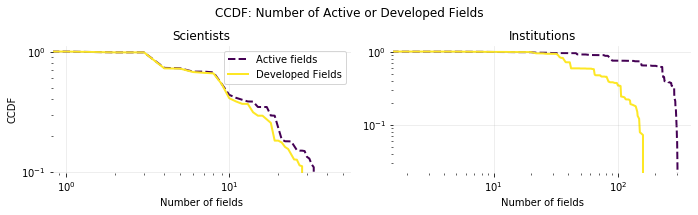

In [10]:
plt.rcParams["figure.figsize"] = (9.8,3)
col = plt.cm.viridis([0,1.1])
fig = plt.figure()
fig.suptitle("CCDF: Number of Active or Developed Fields")
t = ["Scientists", "Institutions"]

for f in range(len(Us)):
    ax = fig.add_subplot(1,2,f+1)
    for i in range(len(Us[f])):
        dis = Us[f][i]
        d = [0]+sorted([dis[k] for k in dis])
        if f == 0 and i == 0:
            d = [x for x in d if x < 51]
        X, F = np.unique(d, return_index=True)
        ccdf = 1-F/F.max()
        if i == 0:
            plt.plot(X,ccdf,lw=2,zorder=1,color=col[i], linestyle='--')
        else:
            plt.plot(X,ccdf,lw=2,zorder=1,color=col[i])

    plt.title(t[f])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('CCDF')
    plt.xlabel('Number of fields')
    if f%2 == 0:
        plt.legend(['Active fields', 'Developed Fields'])
        plt.ylabel('CCDF')
    else:
        plt.ylabel('')
    plt.box(False)
    plt.tight_layout()

    ax.yaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax.yaxis.grid(zorder=0)
    ax.xaxis.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.2)
    ax.xaxis.grid(zorder=0)

fig.subplots_adjust(top=0.8)
plt.savefig("nfields.pdf",bbox_inches='tight')

TEXT

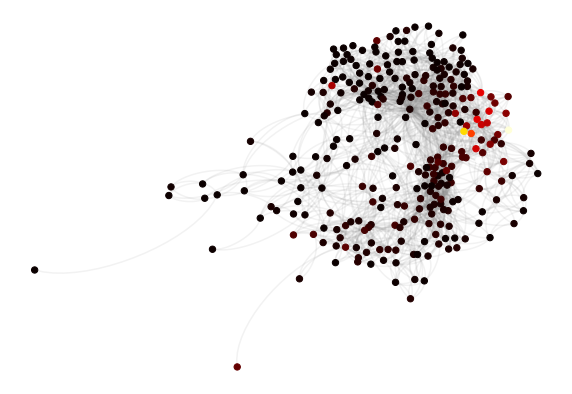

In [46]:
uni = "universidade federal de lavras"
vals = list()
vals_dict = dict()
for f in indices:
    if (uni, f) in institutions.rca:
        vals.append(institutions.rca[(uni, f)])
        vals_dict[f] = institutions.rca[(uni, f)]
    else:
        vals.append(0)
        vals_dict[f] = 0

pos = maps.plot("guevara(2000, 2014, 0.1)", vals)

TEXT

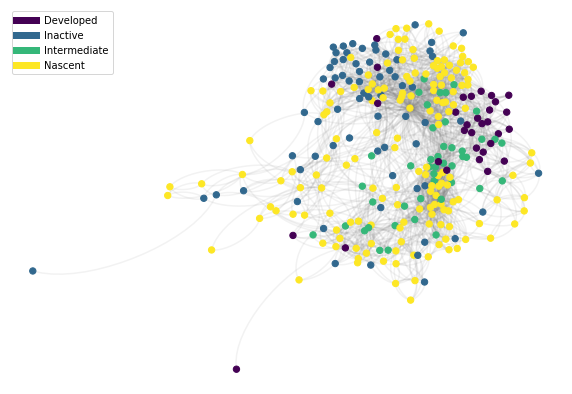

In [47]:
def rca_disc(val):
    if val == 0:
        return "Inactive"
    if val < 0.5:
        return "Nascent"
    if val < 1:
        return "Intermediate"
    else:
        return "Developed"

dict_area = {f: rca_disc(vals_dict[f]) for f in vals_dict}
unique = ["Inactive", "Nascent", "Intermediate", "Developed"]
subs = {u: v for v,u in enumerate(sorted(unique))}
values = [subs[dict_area[node]] for node in indices]

pos = maps.plot("guevara(2000, 2014, 0.1)", values, labels=subs)